### 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
from sklearn.metrics.cluster import adjusted_rand_score

import random, torch
import SpaGCN as spg

import WEST_plt

file_path = '/home/stat/cai/WEST/data/simulation/circle_grid_disp_0.2/'

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2024-05-22 16:27:14.892078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:27:15.115495: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 16:27:16.119296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: lib

### 2. Load data

In [2]:
#### Read data from pickle
with open(file_path+'raw_data.pkl', 'rb') as file:
    adata = pickle.load(file)

### 3. Preprocess

In [3]:
%%capture captured_output
adj = spg.pairwise_distance(adata.obs[['loc_x', 'loc_y']].to_numpy().astype(np.float32))
p=0.5; 
r_seed=t_seed=n_seed=1234
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

# preprocess
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4. Model training

In [7]:
# parameter tuning
l = spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)
n_clusters = len(adata.obs['true cluster'].unique())
res = spg.search_res(adata, adj, l, target_num=5, start=0.1, step=0.1, tol=5e-3, lr=0.05, max_epochs=200, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

# train
clf = spg.SpaGCN()
clf.set_l(l)
clf.train(adata ,adj, num_pcs=50, init_spa=True, init='louvain', res=res, tol=5e-3, lr=0.05, max_epochs=500)
y_pred, prob = clf.predict()
adata.obs['SpaGCN']= y_pred

# get new embedding
z,q = clf.model.predict(clf.embed,clf.adj_exp)
SpaGCN_embedding = z.detach().numpy()
adata.obsm['SpaGCN'] = SpaGCN_embedding

Run 1: l [0.01, 1000], p [0.0, 1874.9664062185566]
Run 2: l [0.01, 500.005], p [0.0, 1874.86572265625]
Run 3: l [0.01, 250.0075], p [0.0, 1874.462646484375]
Run 4: l [0.01, 125.00874999999999], p [0.0, 1872.852294921875]
Run 5: l [0.01, 62.509375], p [0.0, 1866.4351806640625]
Run 6: l [0.01, 31.2596875], p [0.0, 1841.13916015625]
Run 7: l [0.01, 15.63484375], p [0.0, 1745.548583984375]
Run 8: l [0.01, 7.822421875], p [0.0, 1436.6173095703125]
Run 9: l [0.01, 3.9162109375], p [0.0, 817.0928955078125]
Run 10: l [0.01, 1.9631054687499998], p [0.0, 298.5187683105469]
Run 11: l [0.01, 0.9865527343749999], p [0.0, 87.60859680175781]
Run 12: l [0.01, 0.49827636718749996], p [0.0, 23.29397201538086]
Run 13: l [0.01, 0.25413818359374996], p [0.0, 5.545017719268799]
Run 14: l [0.01, 0.13206909179687498], p [0.0, 0.827502965927124]
Run 15: l [0.0710345458984375, 0.13206909179687498], p [0.010255217552185059, 0.827502965927124]
Run 16: l [0.10155181884765624, 0.13206909179687498], p [0.22431635856

### 4. Clustering

In [8]:
ARI = adjusted_rand_score(adata.obs['SpaGCN'], adata.obs['true cluster']) 
print('ARI: ', ARI)
print(adata.obs['SpaGCN'].unique())

ARI:  0.3032948651100254
[0 5 1 4 2]


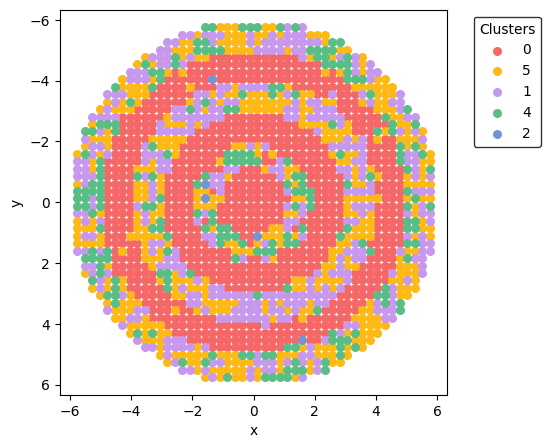

In [9]:
WEST_plt.WEST_scatter(adata, reps='SpaGCN', invert_y=True, s=30)

### 5. Save embedding

In [10]:
np.savetxt(file_path+'SpaGCN_embedding.csv',SpaGCN_embedding, delimiter=',')
np.savetxt(file_path+'SpaGCN_cluster.csv', adata.obs['SpaGCN'], delimiter=',', fmt='%s')